# Exercise 1
## Céline Budding && Dorothea Müller

# Configurations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.signal import gaussian

%matplotlib inline

# 1. Frequency Content of Natural Images and Fourier Transform

## 1.

In [2]:
# (i) Random vector.
n = 500
v = np.random.random(n)

In [3]:
# (ii) Fourier transform.
v_fourier = np.fft.fft(v)

In [4]:
# (iii) Creating filter.
spatial_freq = np.fft.fftfreq(n)

In [5]:
def power_spectral_density(k, eps):
    # TODO: remove abs(k)?
    return 1/(eps + np.abs(k)**2)

In [6]:
all_eps = [0.001, 0.01, 0.1, 0.5, 1]

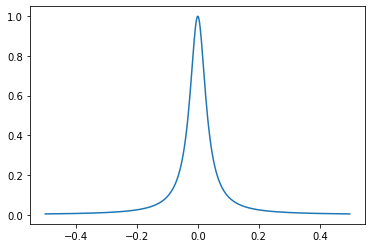

/home/dorothea/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


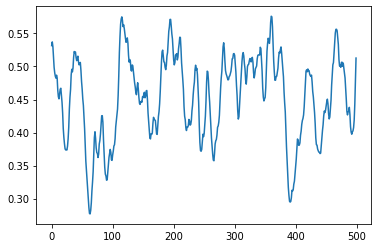

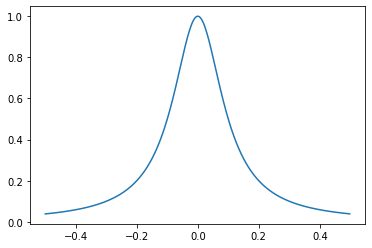

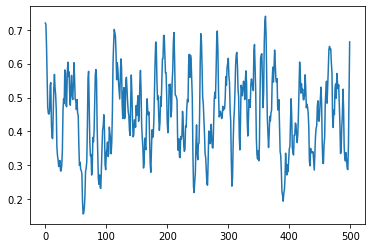

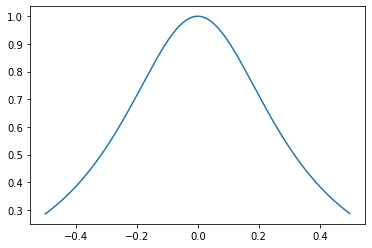

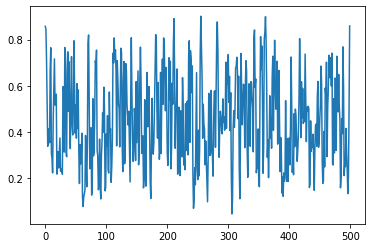

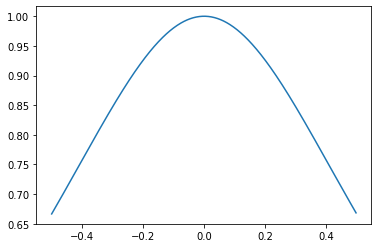

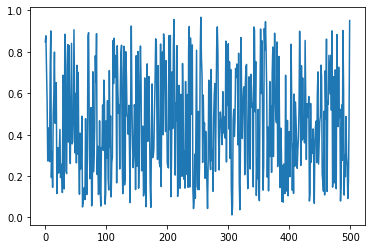

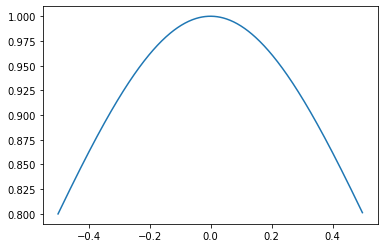

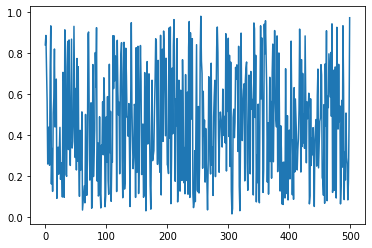

In [7]:
for eps in all_eps:
    filter_ = power_spectral_density(spatial_freq, eps) * eps
    filtered_v = filter_ * v_fourier
    # (iv) Inverse Fourier transform.
    v = np.fft.ifft(filtered_v)
    
    psd_x = np.fft.fftshift(spatial_freq)
    psd_y = np.fft.fftshift(filter_)
    plt.plot(psd_x, psd_y)
    plt.show()
    plt.plot(v)
    plt.show()

## What is the effect of e?

The filter is a low-pass filter as higher frequencies get filtered out. The lower e is, the more gets filtered out.

## 2.

In [8]:
img = np.random.random((n, n))
img_fourier = np.fft.fft2(img)

In [9]:
spatial_freq_x = np.fft.fftfreq(n)
spatial_freq_y = np.fft.fftfreq(n)
xx, yy = np.meshgrid(spatial_freq_x, spatial_freq_y)

In [10]:
def power_spectral_density_2d(xx, yy, eps):
    # TODO: remove np.sqrt and **2?
    return 1/(eps + np.sqrt(xx**2 + yy**2)**2)

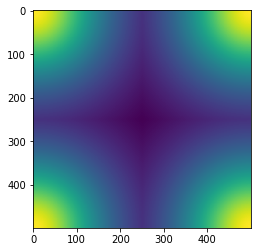

In [11]:
plt.imshow(power_spectral_density_2d(xx,yy, 0.1))

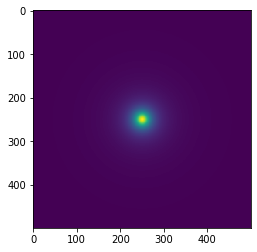

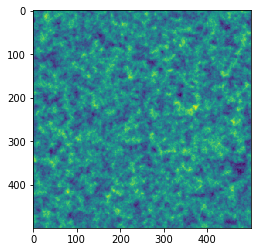

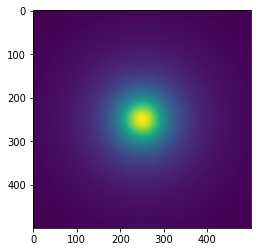

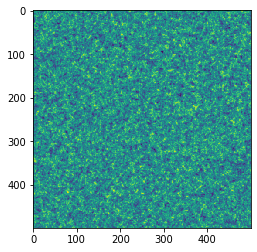

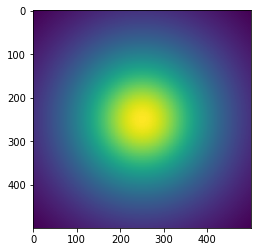

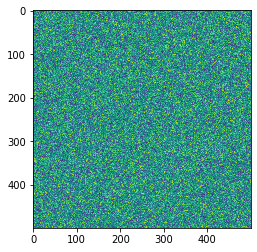

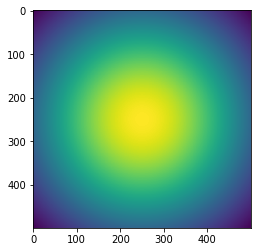

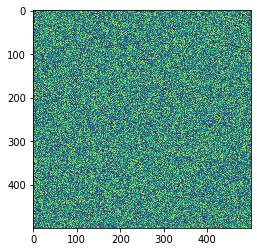

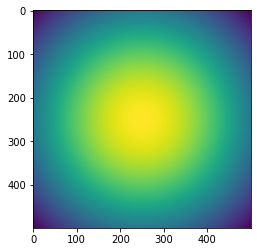

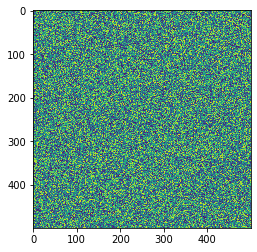

In [12]:
for eps in all_eps:
    filter_ = power_spectral_density_2d(xx,yy, eps) * eps
    filtered_img = filter_ * img_fourier
    img = np.fft.ifft2(filtered_img)#.astype(float)
    
#     psd_x = np.fft.fftshift(spatial_freq)
    psd = np.fft.fftshift(filter_)
    plt.imshow(psd)
    plt.show()
    plt.imshow(img.real)
    plt.show()

The created images do not look natural because the structure is random, there is no order in the images. Adjacent pixels are usually correlated. Therefore, to create natural looking images, we should enforce some structure on the output. 

## 3.

(330, 250)


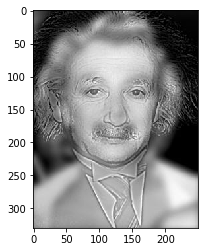

In [13]:
path = './hybrid.png'
img = imread(path)
print(img.shape)
plt.imshow(img, cmap = 'gray');

In [14]:
all_sigmas = [1, 5, 10, 25, 50, 100]

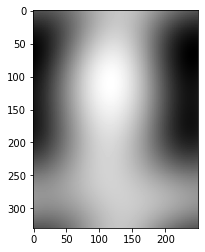

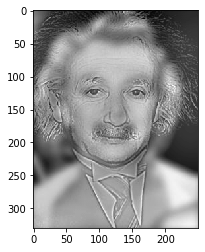

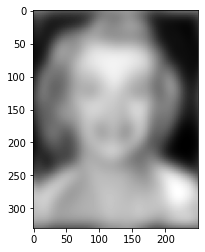

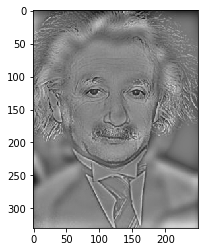

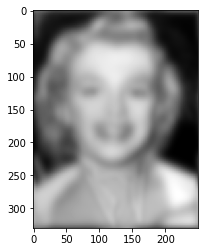

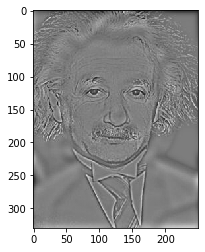

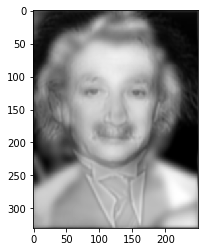

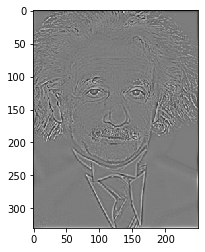

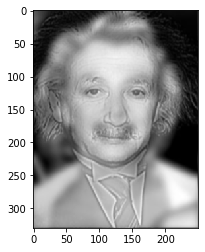

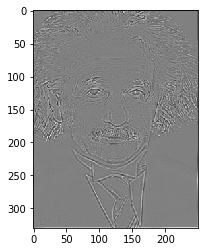

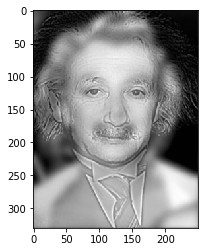

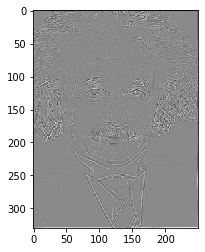

In [15]:
for sigma in all_sigmas:
    gauss_dim1 = gaussian(img.shape[0], sigma)
    gauss_dim2 = gaussian(img.shape[1], sigma)
    gauss_filter = np.outer(gauss_dim1, gauss_dim2)
    gauss_filter = np.fft.fftshift(gauss_filter)
    
    filter_inv = 1 - gauss_filter
    
    img_fourier = np.fft.fft2(img)
    
    img_filtered = gauss_filter * img_fourier
    img_final = np.fft.ifft2(img_filtered)
    
    img_inv_filtered = filter_inv * img_fourier
    img_final_inv = np.fft.ifft2(img_inv_filtered)

    plt.imshow(img_final.real, cmap = 'gray')
    plt.show()
    
    plt.imshow(img_final_inv.real, cmap = 'gray')
    plt.show()

**Why does generating the filter in this manner work?**

As we are in the frequency domain, we are considering density functions, so we are expecting the corresponding high-pass filter to a low-pass filter to be the inverse.

**Is there an equivalent approach that doesn't require computing the high-pass filter kernel?**

We could also do a convolution with a point filter in the spatial domain.

**How did the filtering process change the visual impressions?**

Low-pass filtering showed Monroe as it highlighted the gradual changes in the image.
High-pass filtering showed Einstein as it highlighted the edges more and more.

**Can you find a relation to what is happening when you look at the image close-up or from a distance?**

At a distance you see more Marilyn Monroe (low frequencies) and in a close-up, you focus more on the high frequencies, thus seeing Einstein. We are quite impressed by this experimental result.

# 2. "Natural Input" for the Cell in the Early Visual System

### 1.

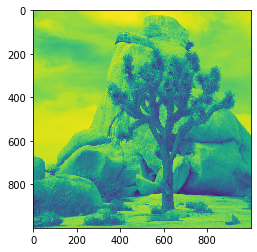

In [16]:
path = "./natural/natural1.png"

img = imread(path)
plt.imshow(img);

### 2.

In [17]:
def x_in_border(img, x, x_half):
    return x + x_half < img.shape[1] and x - x_half > 0

def y_in_border(img, y, y_half):
    return y + y_half < img.shape[0] and y - y_half > 0

In [18]:
def extract_patch(img, l_x, l_y, x, y):
    """Extract patches from the img from position x, y with length l_x and l_y, respectively.
    Returns None if parts of the patch are not within the borders."""
    
    x_half = l_x//2
    y_half = l_y//2
    
    if not x_in_border(img, x, x_half):
        return None
    if not y_in_border(img, y, y_half):
        return None
    
    # Cave. Assuming x should be the horizontal direction and y the vertical,
    # the accesses has to be img[y, x].
    return img[y-y_half:y+y_half, x-x_half:x+x_half]

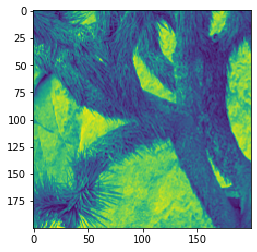

Dim: (200, 200)


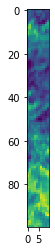

Dim: (100, 10)


In [19]:
# Testing.
extracted = extract_patch(img, 200, 200, 500, 500)
plt.imshow(extracted)
plt.show()
print(f"Dim: {extracted.shape}")

extracted = extract_patch(img, 10, 100, 400, 850)
plt.imshow(extracted)
plt.show()
print(f"Dim: {extracted.shape}")

extracted = extract_patch(img, 100, 100, 50000, 500)
assert extracted is None

### 3. Micro-Saccades

In [20]:
l_x = 25
l_y = 25

In [21]:
def generate_sequence(title, sigma=4):
    """Generate sequence of 10 images, each. Sample new fixation point from normal distribution
    with mean 0 and standard deviation sigma."""
    position = (np.random.randint(250, 750), np.random.randint(250, 750))

    sequence_positions = []
    sequence_positions.append(position) # Starting position.
    fig, axs = plt.subplots(2, 5, figsize = (10, 5))

    for i, ax in enumerate(axs.flat):    
        # Extract image.
        extr_img = None
        
        while extr_img is None:
            # New positions.
            x, y = position
            ch_x, ch_y = np.random.normal(0, sigma, 2)
            x+= int(ch_x) # Cast to pixels.
            y+= int(ch_y)
            position = x, y
            
            extr_img = extract_patch(img, l_x, l_y, x, y)
            
            
        sequence_positions.append(position)
        
        ax.imshow(extr_img)
        ax.set_title(f"t = {i + 1}")
        ax.set_xlabel('x [px]')
        ax.set_ylabel('y [px]')

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    return sequence_positions

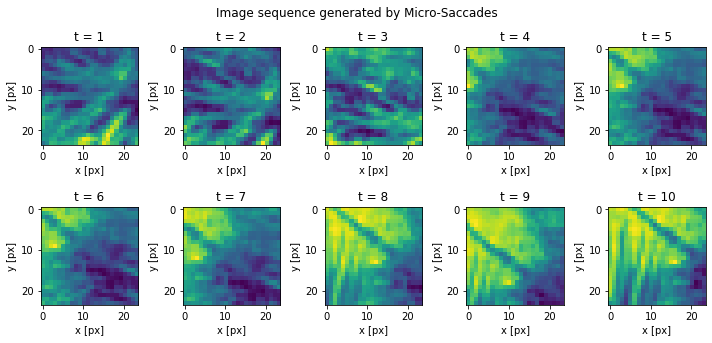

In [22]:
seq_title = "Image sequence generated by Micro-Saccades"
sequence_pos = generate_sequence(seq_title)

In [23]:
# Sequence was used with by generating following jumps:
sequence_pos

[(563, 267),
 (564, 266),
 (563, 261),
 (558, 255),
 (550, 249),
 (547, 249),
 (547, 249),
 (547, 246),
 (538, 245),
 (540, 240),
 (534, 245)]

### 4. Saccades

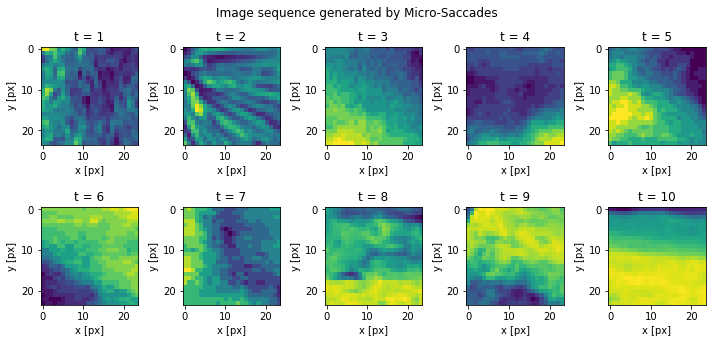

In [24]:
# We know 4 pixels is 10 arcminutes and 10 degrees are 600 arcminutes.
sigma = 4/10 * 600
seq_title = "Image sequence generated by Micro-Saccades"
sequence_pos = generate_sequence(seq_title, sigma)

In [25]:
# Sequence was used with by generating following jumps:
sequence_pos

[(406, 704),
 (674, 578),
 (782, 489),
 (21, 204),
 (269, 428),
 (181, 256),
 (238, 13),
 (743, 53),
 (867, 891),
 (485, 768),
 (913, 866)]

### 5. Comparison Micro-Saccades and Saccades

**What are the differences between Micro-Saccades and Saccades?**

The micro-saccades are close to each other, so we see the same object. However, with the saccades we see different objects in the image because the saccading jumps are larger so we visit different parts of the image.

### 6. Different Natural Image.

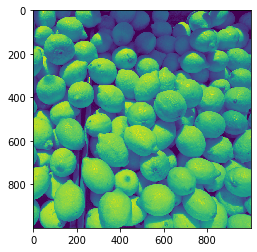

In [26]:
path = "./natural/natural4.png"

img = imread(path)
plt.imshow(img);

In [ ]:
_ = generate_sequence("Image sequence generated by Micro-Saccades")
_ = generate_sequence("Image sequence generated by Saccades", sigma)

**Do you observe difference regarding the resulting image sequences?**

There is more similarity between the saccades than in the previous picture.

**What could be the reason?**

There is less variation (ie. the image is more repetivie regarding its elements) than in the first image we used.